**Custom Knowledge ChatGPT with LangChain - Chat with PDFs**

In [ ]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

**Imports and API Keys**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [ ]:
os.environ['OPENAI_API_KEY']='Your API KEY'

**1. Loading PDFs and chunking with LangChain**

In [ ]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("./Tableau.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='Ryan  SleeperPractical Tableau\n100 TIPS, TUTORIALS, AND STRATEGIES  \nFROM A TABLEAU ZEN MASTER' metadata={'source': './Tableau.pdf', 'page': 0}


In [ ]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./Tableau.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('Tableau.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('Tableau.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [ ]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

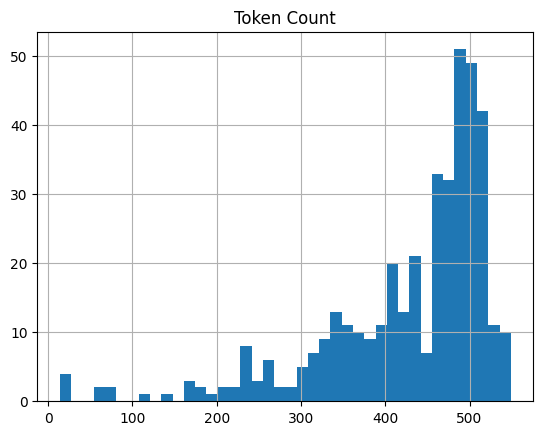

In [ ]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

**2. Embed text and store embeddings**

In [ ]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

**3. Setup retrieval function**

In [ ]:
# Check similarity search is working
query = "What is box plot?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='| \n\n173\n\n\x0c\x0cCHAPTER 29\nHow to Make a Box-and-Whisker Plot\n\nThe box-and-whisker plot, or box plot, is another effective visualization choice for\nillustrating  distributions.  Along  with  histograms  and  stacked  area  charts,  box-and-\nwhisker plots are among my favorite chart types used for this purpose. They work\nparticularly  well  when  you  want  to  compare  the  distributions  across  two  different\ndimension  members  side-by-side,  where  one  set  of  dimension  members  makes  up\nthe  x-axis,  and  the  other  dimension  member  is  used  as  the  visualization’s  level  of\ndetail. To help illustrate, here’s the box-and-whisker plot we will create with the Sam‐\nple – Superstore dataset during this tutorial:\n\n175\n\n\x0cAs you can see, each set of circles corresponds to the dimension members on the x-\naxis for the Sub-Category dimension. The level of detail, or most granular level of the\nanalysis, is Month of Order Date. Since th

In [ ]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "What is box plot?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' A box-and-whisker plot, or box plot, is a visualization choice for illustrating distributions. It works particularly well when you want to compare the distributions across two different dimension members side-by-side, where one set of dimension members makes up the x-axis, and the other dimension member is used as the visualization’s level of detail. Each set of circles corresponds to the dimension members on the x-axis for the Sub-Category dimension. The level of detail, or most granular level of the analysis, is Month of Order Date. The most important line is the one right in the middle of each “box,” which represents median. With median displayed, you can quickly look across the dimension members and compare medians, regardless of how big or small the range of values is within each column. Working out from the median, the next set of lines is showing plus or minus one quartile from the median. Lastly, the upper whisker is 50% higher than the IQR, or “middle fifty,” which are the d

**5. Create chatbot with chat memory (OPTIONAL)**

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> what is box plo')

HTML(value='<b><font color="blue">Chatbot:</font></b>  A box-and-whisker plot, or box plot, is a visualization…